# Methylation data from Nanopolish HGSVC3

Intersected G4 annotationas from specific haplotype and matched it to methylation file from Nanopolish

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("/home/alextu/scratch/methylation_data/results/HG00096/G4_meth_intersect_HG00096_hap2_negstrand.tsv", sep="\t")

In [3]:
print(df.shape)

(313572, 14)


First few rows of the DataFrame:
  G4_chr  G4_start   G4_end   G4_Q meth_chr  meth_start  meth_end  \
0   chr1   1432118  1432349  50.78     chr1     1432139   1432139   
1   chr1   1432118  1432349  50.78     chr1     1432317   1432332   
2   chr1   1432118  1432349  50.78     chr1     1432345   1432353   
3   chr1   1432118  1432349  50.78     chr1     1432139   1432139   
4   chr1   1432118  1432349  50.78     chr1     1432317   1432332   

                              meth_read  log_lik_ratio  log_lik_methylated  \
0  7cdb3603-e1d4-4443-9175-af602629f01c           1.95             -123.67   
1  7cdb3603-e1d4-4443-9175-af602629f01c           5.52             -267.81   
2  7cdb3603-e1d4-4443-9175-af602629f01c           1.73             -187.34   
3  7c786b5f-007d-4858-aa59-e855d5116639           6.64             -152.32   
4  7c786b5f-007d-4858-aa59-e855d5116639          14.47             -334.79   

   log_lik_unmethylated  num_calling_strands  num_motifs  \
0               -125.63

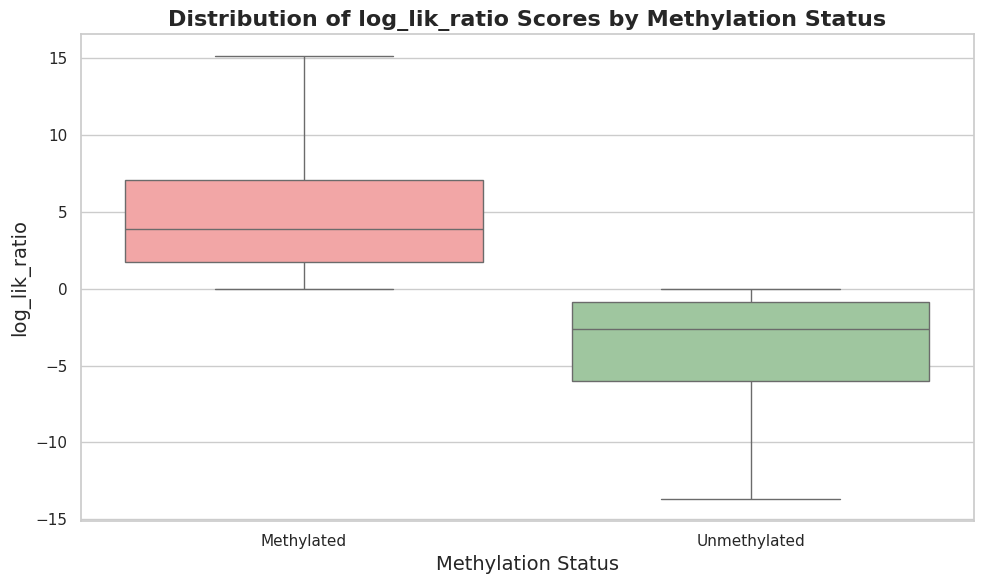

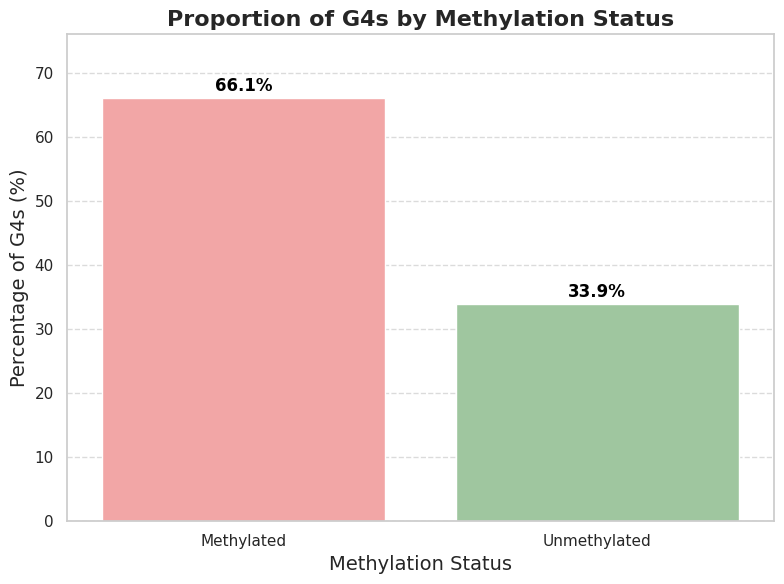

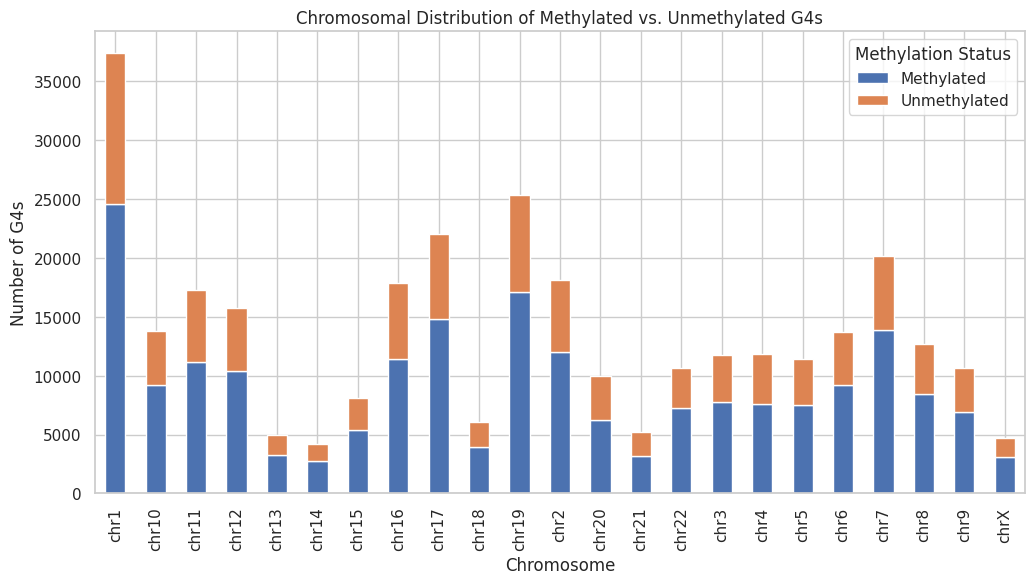

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Assign Column Names
column_names = [
    'G4_chr', 'G4_start', 'G4_end', 'G4_Q',
    'meth_chr', 'meth_start', 'meth_end', 'meth_read',
    'log_lik_ratio', 'log_lik_methylated', 'log_lik_unmethylated',
    'num_calling_strands', 'num_motifs', 'sequence'
]

# Replace with your actual file path
df = pd.read_csv(
    '/home/alextu/scratch/methylation_data/results/HG00096/G4_meth_intersect_HG00096_hap2_negstrand.tsv',
    sep='\t',
    header=None,
    names=column_names
)

# Verify the DataFrame
print("First few rows of the DataFrame:")
print(df.head())

# Step 2: Analyze Methylated vs. Unmethylated G4s
df['Methylation_Status'] = df['log_lik_ratio'].apply(
    lambda x: 'Methylated' if x > 0 else 'Unmethylated'
)

# Count the number of methylated vs. unmethylated G4s
methylation_counts = df['Methylation_Status'].value_counts()
print("\nMethylation Counts:")
print(methylation_counts)

# Calculate proportions (percentage) of each category
total_g4s = len(df)
methylation_proportions = (methylation_counts / total_g4s) * 100
print("\nMethylation Proportions (%):")
print(methylation_proportions)

# Step 3: Create Boxplot for log_lik_ratio by Methylation Status
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

sns.boxplot(
    x='Methylation_Status',
    y='log_lik_ratio',
    data=df,
    hue='Methylation_Status',          # Assign hue to fix the warning
    palette=['#FF9999', '#99CC99'],    # Define colors for each category
    dodge=False,                        # Prevent overlapping boxes
    showfliers=False                    # Hide outliers (optional)
)

# Remove the redundant legend
plt.legend([], [], frameon=False)

# Add titles and labels
plt.title('Distribution of log_lik_ratio Scores by Methylation Status', fontsize=16, fontweight='bold')
plt.xlabel('Methylation Status', fontsize=14)
plt.ylabel('log_lik_ratio', fontsize=14)

# Optionally adjust y-axis limits to focus on main distribution
# plt.ylim(-200, 200)  # Uncomment and adjust as needed

# Show the plot
plt.tight_layout()
plt.show()

# Step 4: Create Bar Plot for Proportion of G4s in Each Category
plt.figure(figsize=(8, 6))

# Create a bar plot for proportions
sns.barplot(
    x=methylation_proportions.index,
    y=methylation_proportions.values,
    hue=methylation_proportions.index,  # Assign hue to fix the FutureWarning
    palette=['#FF9999', '#99CC99'],
    dodge=False
)

# Remove the redundant legend
plt.legend([], [], frameon=False)

# Add percentage labels on top of each bar
for index, value in enumerate(methylation_proportions.values):
    plt.text(
        index, 
        value + 0.5,  # Position text slightly above the bar
        f"{value:.1f}%", 
        ha='center', 
        va='bottom',
        fontsize=12,
        fontweight='bold',
        color='black'
    )

# Add titles and labels
plt.title('Proportion of G4s by Methylation Status', fontsize=16, fontweight='bold')
plt.xlabel('Methylation Status', fontsize=14)
plt.ylabel('Percentage of G4s (%)', fontsize=14)

# Set y-axis limits to accommodate labels
plt.ylim(0, methylation_proportions.values.max() + 10)

# Add gridlines for y-axis
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

chrom_methylation = df.groupby(['G4_chr', 'Methylation_Status']).size().unstack()
chrom_methylation.plot(kind='bar', stacked=True, figsize=(12,6))
plt.title("Chromosomal Distribution of Methylated vs. Unmethylated G4s")
plt.xlabel("Chromosome")
plt.ylabel("Number of G4s")
plt.legend(title="Methylation Status")
plt.show()

Methylation Counts:
Methylation_Status
Methylated      196621
Unmethylated     99755
Name: count, dtype: int64

Descriptive Statistics for G4_Q:
                       count       mean       std    min    25%    50%    75%  \
Methylation_Status                                                              
Methylated          196621.0  29.519857  6.051831  19.01  24.79  29.51  33.62   
Unmethylated         99755.0  29.246989  6.037908  19.01  24.37  29.33  33.29   

                      max  
Methylation_Status         
Methylated          54.14  
Unmethylated        53.86  


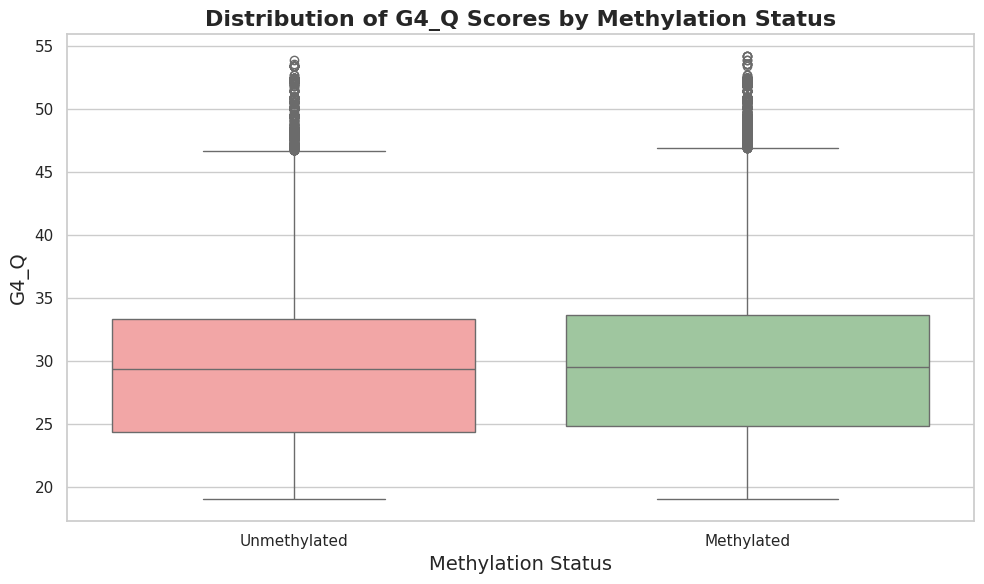

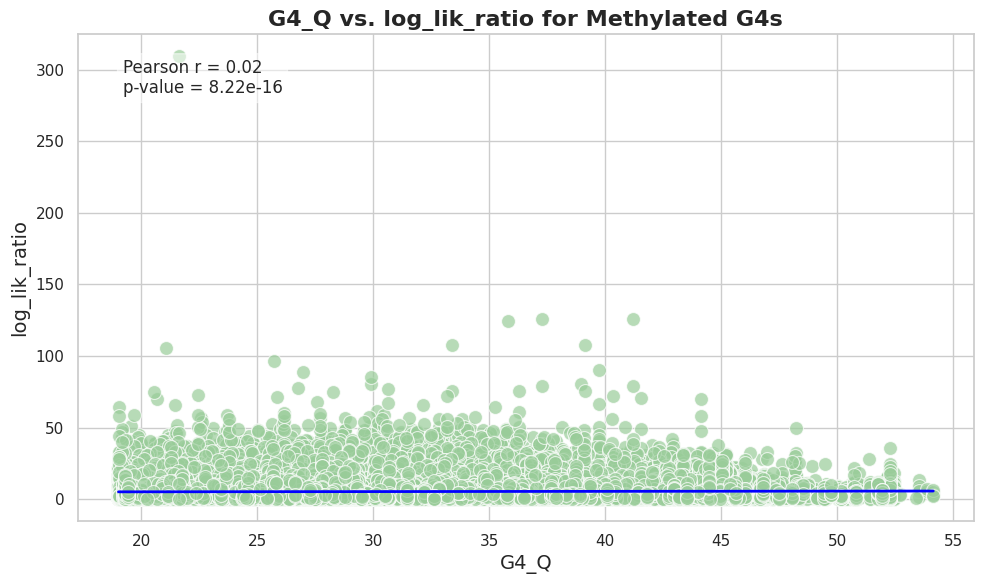

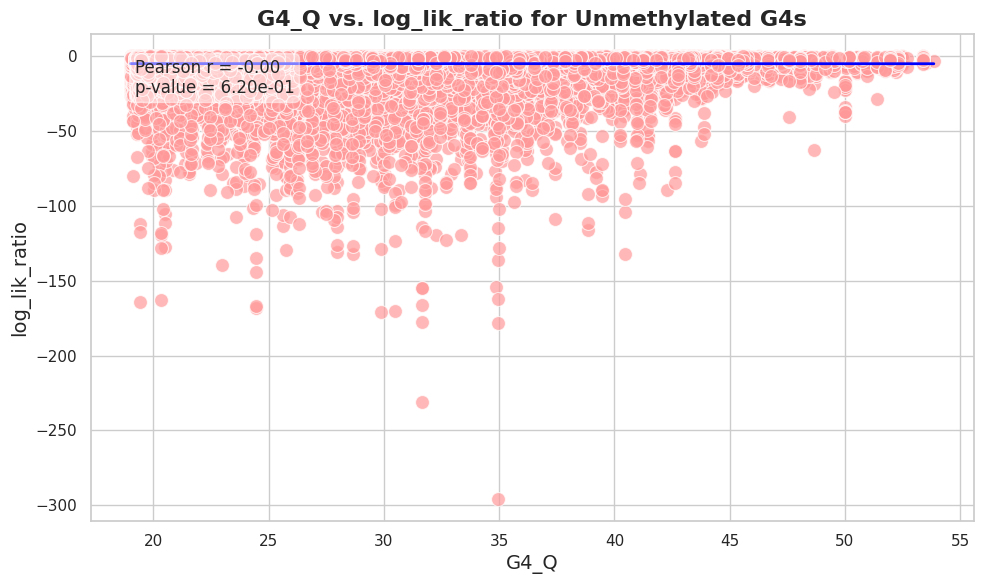


Mann-Whitney U Test Results:
U Statistic = 10049050361.5
p-value = 3.8577803237299103e-28
Result: Significant difference in G4_Q between Methylated and Unmethylated groups (Mann-Whitney U Test).

Independent T-Test Results:
T Statistic = 11.61687531903554
p-value = 3.4615063133238284e-31
Result: Significant difference in G4_Q between Methylated and Unmethylated groups (Independent T-Test).


In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu, ttest_ind, pearsonr

# Step 1: Assign Column Names and Read Data
column_names = [
    'G4_chr', 'G4_start', 'G4_end', 'G4_Q',
    'meth_chr', 'meth_start', 'meth_end', 'meth_read',
    'log_lik_ratio', 'log_lik_methylated', 'log_lik_unmethylated',
    'num_calling_strands', 'num_motifs', 'sequence'
]

# Read the TSV file
df = pd.read_csv(
    '/home/alextu/scratch/methylation_data/G4_meth_intersect_HG00096_hap1_negstrand.tsv',
    sep='\t',
    header=None,
    names=column_names
)

# Step 2: Analyze Methylated vs. Unmethylated G4s
df['Methylation_Status'] = df['log_lik_ratio'].apply(
    lambda x: 'Methylated' if x > 0 else 'Unmethylated'
)

# Display counts
methylation_counts = df['Methylation_Status'].value_counts()
print("Methylation Counts:")
print(methylation_counts)

# Calculate descriptive statistics for G4_Q
descriptive_stats = df.groupby('Methylation_Status')['G4_Q'].describe()
print("\nDescriptive Statistics for G4_Q:")
print(descriptive_stats)

# Step 3: Create Boxplot with Swarmplot for G4_Q
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Boxplot
sns.boxplot(
    x='Methylation_Status',
    y='G4_Q',
    data=df,
    hue='Methylation_Status',
    palette=['#FF9999', '#99CC99'],
    dodge=False,
    showfliers=True
)

# Remove the redundant legend
plt.legend([], [], frameon=False)

# Add titles and labels
plt.title('Distribution of G4_Q Scores by Methylation Status', fontsize=16, fontweight='bold')
plt.xlabel('Methylation Status', fontsize=14)
plt.ylabel('G4_Q', fontsize=14)

# Optionally adjust y-axis limits to focus on main distribution
# plt.ylim(0, 30)  # Uncomment and adjust as needed

# Show the plot
plt.tight_layout()
plt.show()

# Step 4: Create Separate Scatter Plots with Regression and Correlation

# Define a function to create scatter plots with regression and correlation
def scatter_with_regression(data, status):
    plt.figure(figsize=(10, 6))
    
    # Scatter Plot
    sns.scatterplot(
        x='G4_Q',
        y='log_lik_ratio',
        data=data,
        color='#99CC99' if status == 'Methylated' else '#FF9999',
        edgecolor='w',
        s=100,
        alpha=0.7
    )
    
    # Regression Line
    sns.regplot(
        x='G4_Q',
        y='log_lik_ratio',
        data=data,
        scatter=False,
        color='blue',
        line_kws={'linewidth': 2}
    )
    
    # Calculate Pearson Correlation
    corr_coef, p_value = pearsonr(data['G4_Q'], data['log_lik_ratio'])
    
    # Annotate Correlation Coefficient
    plt.text(
        0.05, 0.95, 
        f'Pearson r = {corr_coef:.2f}\np-value = {p_value:.2e}',
        transform=plt.gca().transAxes,
        fontsize=12,
        verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.5)
    )
    
    # Add titles and labels
    plt.title(f'G4_Q vs. log_lik_ratio for {status} G4s', fontsize=16, fontweight='bold')
    plt.xlabel('G4_Q', fontsize=14)
    plt.ylabel('log_lik_ratio', fontsize=14)
    
    # Improve legend (optional, since plots are separate)
    # plt.legend(title='Methylation Status')
    
    # Show the plot
    plt.tight_layout()
    plt.show()

# Separate the data into two groups
methylated_df = df[df['Methylation_Status'] == 'Methylated']
unmethylated_df = df[df['Methylation_Status'] == 'Unmethylated']

# Create scatter plots for each group
scatter_with_regression(methylated_df, 'Methylated')
scatter_with_regression(unmethylated_df, 'Unmethylated')

# Step 5: Statistical Testing
# Mann-Whitney U Test
stat_mw, p_mw = mannwhitneyu(methylated_df['G4_Q'], unmethylated_df['G4_Q'], alternative='two-sided')
print(f'\nMann-Whitney U Test Results:\nU Statistic = {stat_mw}\np-value = {p_mw}')

# Interpretation
alpha = 0.05
if p_mw < alpha:
    print("Result: Significant difference in G4_Q between Methylated and Unmethylated groups (Mann-Whitney U Test).")
else:
    print("Result: No significant difference in G4_Q between Methylated and Unmethylated groups (Mann-Whitney U Test).")

# Independent T-Test (Optional)
stat_tt, p_tt = ttest_ind(methylated_df['G4_Q'], unmethylated_df['G4_Q'], equal_var=False)
print(f'\nIndependent T-Test Results:\nT Statistic = {stat_tt}\np-value = {p_tt}')

if p_tt < alpha:
    print("Result: Significant difference in G4_Q between Methylated and Unmethylated groups (Independent T-Test).")
else:
    print("Result: No significant difference in G4_Q between Methylated and Unmethylated groups (Independent T-Test).")